(581012, 54)
[[2.596e+03 5.100e+01 3.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.590e+03 5.600e+01 2.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.804e+03 1.390e+02 9.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [2.386e+03 1.590e+02 1.700e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.384e+03 1.700e+02 1.500e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.383e+03 1.650e+02 1.300e+01 ... 0.000e+00 0.000e+00 0.000e+00]]
(581012,)
[5 5 2 ... 3 3 3]
(481012,)
(253789, 54)
(253789,)
(243978, 54)
(243978,)
0.7700845978352095
Accuracy after query 1: 0.7653
Accuracy after query 2: 0.7652
Accuracy after query 3: 0.7651
Accuracy after query 4: 0.7652
Accuracy after query 5: 0.7652


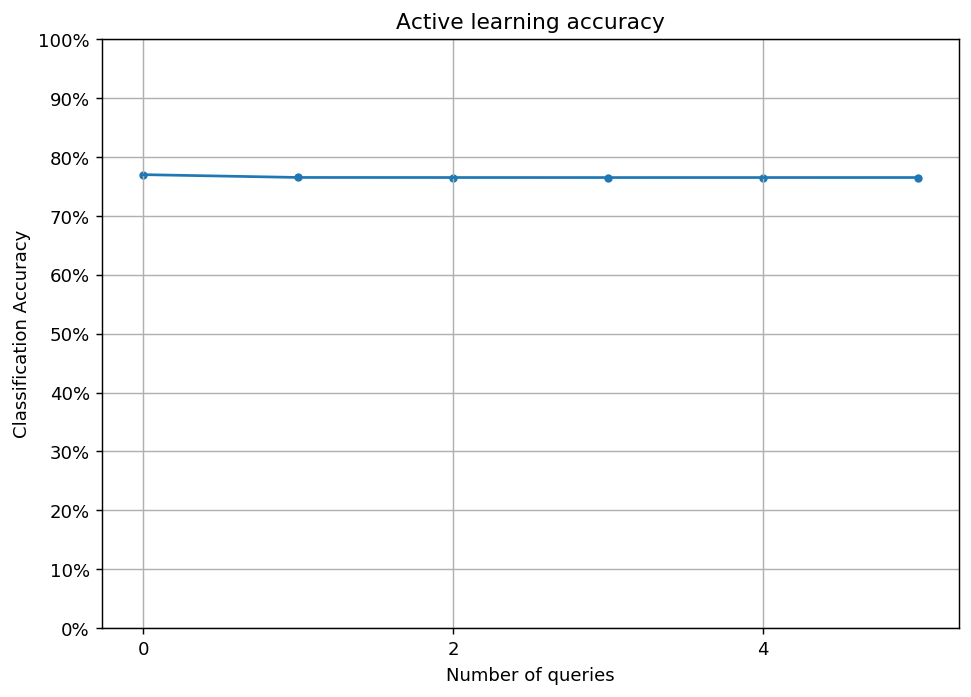

In [2]:
from sklearn.datasets import fetch_covtype
data = fetch_covtype()
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

X_raw = data['data']
y_raw = data['target']

print(X_raw.shape)
print(X_raw)
print(y_raw.shape)
print(y_raw)

#from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
#pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
#transformed_fetch_covtype = pca.fit_transform(X=X_raw)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#Isolate the data we'll need for plotting.
#x_component, y_component = transformed_fetch_covtype[:, 0], transformed_fetch_covtype[:, 1]

#Plot our dimensionality-reduced (via PCA) dataset.
#plt.figure(figsize=(8.5, 6), dpi=130)
#plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
#plt.title('forest cover type classes after PCA transformation')
#plt.show()

# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples - 1, size=481012)
print(training_indices.shape)

X_test = X_raw[training_indices]
y_test = y_raw[training_indices]

X_raw = np.delete(X_raw, training_indices, axis=0)
y_raw = np.delete(y_raw, training_indices, axis=0)
print(X_raw.shape)
print(y_raw.shape)

#.................................
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples - 1, size=10000)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)
print(X_pool.shape)
print(y_pool.shape)



from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, query_strategy=uncertainity_sampling, X_training=X_train, y_training=y_train,)

#Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)


unqueried_score = learner.score(X_raw, y_raw)
print(unqueried_score)

#Plot our classification results.
#fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
#ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
#ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
#ax.legend(loc='lower right')
#ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
#plt.show()

#change this variable to change the number of additional data points, 20 is 10%
N_QUERIES = 5


performance_history = [unqueried_score]

rawpool = X_pool
tarpool = y_pool

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).

for index in range(N_QUERIES):
        
    query_index, query_instance = learner.query(rawpool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = rawpool[query_index].reshape(1, -1), tarpool[query_index].reshape(1, )
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    rawpool, tarpool = np.delete(rawpool, query_index, axis=0), np.delete(tarpool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(rawpool, tarpool)
        
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.set_title('Active learning accuracy')
ax.set_xlabel('Number of queries')
ax.set_ylabel('Classification Accuracy')
plt.show()


